In [1]:
import h5py
import numpy as np
import xarray as xr
import pandas as pd
import geopandas as gdp
from shapely.affinity import translate

import cartopy.crs as ccrs
import cartopy

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.patches import Rectangle
%matplotlib inline

In [2]:
# ASI PRISMA and EO-1 HYPERION
df = pd.DataFrame(
    {'Probe': ['Land', 'Water', 'Wood'],
     'Color': ['#de6b00','#1f78b4','#3FB54B'],
     'Latitude': [-8.61482,-8.7912,-8.7040],
     'Longitude': [116.86549,116.7894,116.8355]})
gdf = gdp.GeoDataFrame(df, crs="EPSG:4326", geometry=gdp.points_from_xy(df.Longitude, df.Latitude))
# sort by label if needed
gdf = gdf.sort_values(by='Probe')
# save to file
gdf.to_file("probs.json", driver="GeoJSON")
gdf

,Probe,Color,Latitude,Longitude,geometry
0,Land,#de6b00,-8.61482,116.86549,POINT (116.86549 -8.61482)
1,Water,#1f78b4,-8.79120,116.78940,POINT (116.78940 -8.79120)
2,Wood,#3FB54B,-8.70400,116.83550,POINT (116.83550 -8.70400)


## Define Metadata

In [3]:
wavelength = [
(443.9 + 442.3)/2, (496.6 + 492.1)/2, (560 + 559)/2, (664.5 + 665)/2,
(703.9 + 703.8)/2, (740.2 + 739.1)/2, (782.5 + 779.7)/2, (835.1 + 833)/2,
(864.8 + 864)/2, (945 + 943.2)/2, (1613.7 + 1610.4)/2, (2202.4 + 2185.7)/2]

## Read Multi-band GeoTiff Dataset (WGS84)

Use gdalbuildvrt tool to produce it from provided multiple GeoTiff files

In [4]:
da = xr.open_rasterio('COPERNICUS_S2_SR_2017_2020.tif')
# scale
#da = da.values/2**14-1
da['band'] = wavelength
#da['fwhm'] = xr.DataArray(fwhm,dims=['band'])
da

<xarray.DataArray (band: 12, y: 1189, x: 1195)>
[17050260 values with dtype=float32]
Coordinates:
  * band     (band) float64 443.1 494.4 559.5 ... 944.1 1.612e+03 2.194e+03
  * y        (y) float64 -8.545 -8.545 -8.545 -8.546 ... -8.864 -8.865 -8.865
  * x        (x) float64 116.7 116.7 116.7 116.7 ... 117.0 117.0 117.0 117.0
Attributes:
    transform:     (0.00026949458523585647, 0.0, 116.71945233857562, 0.0, -0....
    crs:           +init=epsg:4326
    res:           (0.00026949458523585647, 0.00026949458523585647)
    is_tiled:      1
    nodatavals:    (nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan)
    scales:        (1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0)
    offsets:       (0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0)
    descriptions:  ('B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B...

In [5]:
# convert probs to the specified coordinate system
#gdf = gdf.to_crs("EPSG:32750")
#gdf

In [6]:
# bands count
da.band.shape[0]

12

In [16]:
da.band.values

array([ 443.1 ,  494.35,  559.5 ,  664.75,  703.85,  739.65,  781.1 ,
        834.05,  864.4 ,  944.1 , 1612.05, 2194.05])

## COPERNICUS/S2_SR Bands 10/20/60m

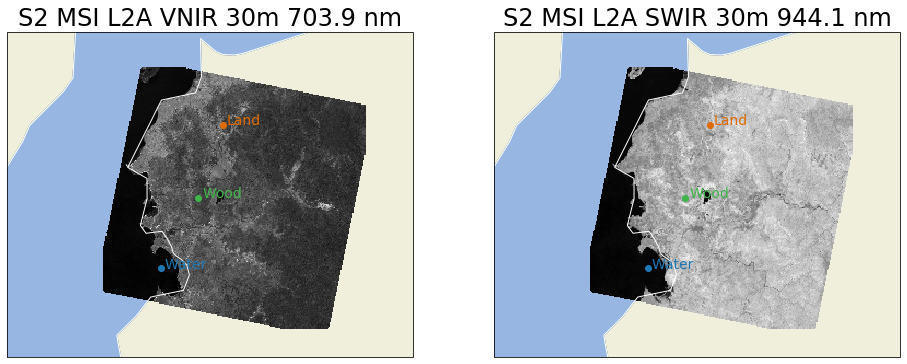

In [18]:
plt.figure(figsize=(16,6))

delta = 0.005

wavelength = 703.85
band_vnir = da.sel(band=wavelength, method='nearest')

ax1 = plt.subplot(1, 2, 1, projection=ccrs.PlateCarree())
ax1.coastlines(color='white')
ax1.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k')
ax1.add_feature(cartopy.feature.OCEAN, zorder=0, edgecolor='lightblue')
ax1.set_global()
band_vnir[::5,::5].plot.pcolormesh(ax=ax1, transform=ccrs.PlateCarree(), cmap="Greys_r", add_colorbar=False)
ax1.set_xlim([116.6,117.1])
ax1.set_ylim([-8.9,-8.5])
ax1.set_title('S2 MSI L2A VNIR 30m %.1f nm' % wavelength,fontsize=24)
# Probs
gdf.apply(lambda x: ax1.annotate(xy=translate(x.loc['geometry'],delta).coords[0],
                                 s=x.Probe, color=x.Color, fontsize=14), axis=1)
gdf.apply(lambda x: ax1.scatter(*x.loc['geometry'].coords[0], c=x.Color), axis=1)

wavelength = 944.1
band_swir = da.sel(band=wavelength)

ax2 = plt.subplot(1, 2, 2, projection=ccrs.PlateCarree())
ax2.coastlines(color='white')
ax2.add_feature(cartopy.feature.LAND, zorder=0, edgecolor='k')
ax2.add_feature(cartopy.feature.OCEAN, zorder=0, edgecolor='lightblue')
ax2.set_global()
band_swir[::5,::5].plot.pcolormesh(ax=ax2, transform=ccrs.PlateCarree(),
                                             cmap="Greys_r", add_colorbar=False)
ax2.set_xlim([116.6,117.1])
ax2.set_ylim([-8.9,-8.5])
ax2.set_title('S2 MSI L2A SWIR 30m %.1f nm' % wavelength,fontsize=24)
# Probs
gdf.apply(lambda x: ax2.annotate(xy=translate(x.loc['geometry'],delta).coords[0],
                                 s=x.Probe, color=x.Color, fontsize=14), axis=1)
gdf.apply(lambda x: ax2.scatter(*x.loc['geometry'].coords[0], c=x.Color), axis=1)

plt.savefig('COPERNICUS_S2_SR VNIR and SWIR Bands.jpg', dpi=150, bbox_inches='tight')
plt.show()

## COPERNICUS/S2_SR Spectrogram of Probe Locations

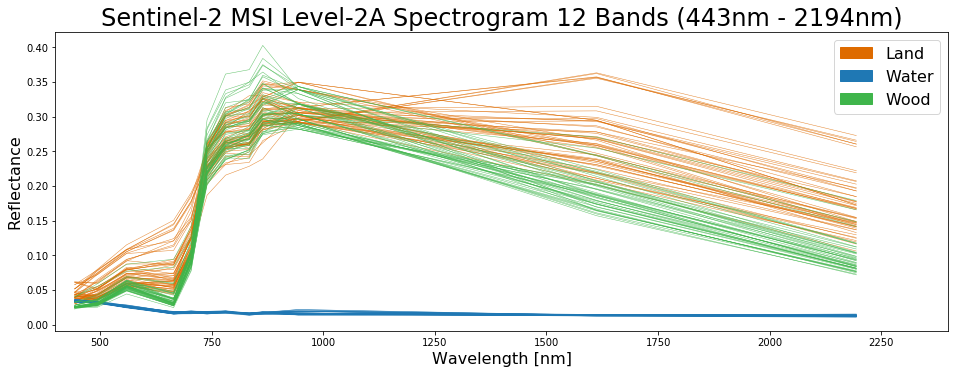

In [19]:
plt.figure(figsize=(16,5.5))
plt.title('Sentinel-2 MSI Level-2A Spectrogram %d Bands (%.0fnm - %.0fnm)' %
          (da.band.shape[0],float(da.band.min()),float(da.band.max())),fontsize=24)
ax = plt.gca()

# for manual legend
patches = []
delta = 1e-3

# plot probes
for (idx,row) in gdf.iterrows():
    #print (row.Probe)
    
    probe = row.Probe
    coords = row.geometry.coords[0]
    color = row.Color

    patches.append(mpatches.Patch(color=color, label=probe))
    da_bands_subset = da.sel(x=slice(coords[0]-delta,coords[0]+delta),y=slice(coords[1]+delta,coords[1]-delta))

    bands_subset = da_bands_subset.to_dataframe(name='value').reset_index().dropna()

    ax = plt.gca()
    for key, grp in bands_subset.groupby(['x','y']):
        grp.plot(ax=ax, kind='line', x='band', y='value', color=color,lw=0.5,alpha=0.8)
    ax.get_legend().remove()

plt.legend(handles=patches, loc='upper right', fontsize=16)

plt.xlabel("Wavelength [nm]",size=16)
plt.ylabel("Reflectance",size=16)
plt.xlim([400,2400])
plt.savefig('COPERNICUS_S2_SR Spectrogram VNIR and SWIR Bands.jpg', dpi=150, bbox_inches='tight')
plt.show()